##recreation of .Vocab from vocab library

In [1]:
import sys
import numpy as np
import torch
import torch.nn.functional as F

class Vocab:
    def __init__(self, tokens, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        """
        A special class that converts lines of tokens into matrices and backwards
        """
        assert all(tok in tokens for tok in (bos, eos, unk))
        self.tokens = tokens
        self.token_to_ix = {t:i for i, t in enumerate(tokens)}
        self.bos, self.eos, self.unk = bos, eos, unk
        self.bos_ix = self.token_to_ix[bos]
        self.eos_ix = self.token_to_ix[eos]
        self.unk_ix = self.token_to_ix[unk]

    def __len__(self):
        return len(self.tokens)

    @staticmethod
    def from_lines(lines, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        flat_lines = '\n'.join(list(lines)).split()
        tokens = sorted(set(flat_lines))
        tokens = [t for t in tokens if t not in (bos, eos, unk) and len(t)]
        tokens = [bos, eos, unk] + tokens
        return Vocab(tokens, bos, eos, unk)

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = [tok if tok in self.token_to_ix else self.unk
                  for tok in string.split()]
        return [self.bos] + tokens + [self.eos]

    def to_matrix(self, lines, dtype=torch.int64, max_len=None):
        """
        convert variable length token sequences into  fixed size matrix
        example usage:
        >>>print(to_matrix(words[:3],source_to_ix))
        [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
         [30 21 15 15 21 14 28 27 13 -1 -1]
         [25 37 31 34 21 20 37 21 28 19 13]]
        """
        lines = list(map(self.tokenize, lines))
        max_len = max_len or max(map(len, lines))

        matrix = torch.full((len(lines), max_len), self.eos_ix, dtype=dtype)
        for i, seq in enumerate(lines):
            row_ix = list(map(self.token_to_ix.get, seq))[:max_len]
            matrix[i, :len(row_ix)] = torch.as_tensor(row_ix)

        return matrix

    def to_lines(self, matrix, crop=True):
        """
        Convert matrix of token ids into strings
        :param matrix: matrix of tokens of int32, shape=[batch,time]
        :param crop: if True, crops BOS and EOS from line
        :return:
        """
        lines = []
        for line_ix in map(list,matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = ' '.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines
    
    def compute_mask(self, input_ix):
        """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
        return F.pad(torch.cumsum(input_ix == self.eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

# Домашняя работа

В этой работе вам предстоит с помощью encoder-decoder архитектуры, пробуя различные ее реализации, решить задачу машинного перевода.

#### Наша задача - сделать свой собственный переводчик!

Пока что только русско-английский:) Будем учиться на текстах описания отелей, так что при успешном выполнении этого задания у вас не возникнет проблем с выбором места для остановки в путешествии, так как все отзывы вам будут высококлассно переведены!

Что необходимо обсудить до начала работы?
 
*как токенезовать и закодировать текст?*

С токенезацией хорошо справится WordPunctTokenizer из библиотеки nltk, а вот с кодированием не все так просто, как может показаться... 

В наших текстах очень много редких и очень мало встречаемых слов (в каждом отеле есть своя фишка: какой-то предмет декорации или услуга, которая описывается своим словом, которое только там и встречается). Если мы будем кодировать все слова, то размер нашего словаря будет очень-очень большим.

Но на одном из семинаров мы кодировали побуквенно, кажется, что тут это может помочь! Да, действительно так, но придется очень очень долго обучать модель, а путешествовать и выбрать хороший отель уже хочется, поэтому мы придем к чему-то среднему между этими подходами -  [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) известный как __BPE__

Этот алгоритм стартует с посимвольного уровня и итеративно мерджит самые встречаемые пары. И так N итераций. На выходе мы получаем самые частые последовательности символов из которых формируются слова!

BPE - очень популярный и частоиспользуемый алгоритм в задачах NLP, поэтому есть много открытых реализаций этого алгоритма

Мы уверены, что вы научились гуглить и искать полезные материалы в интернете, когда делали домашнее задание по YOLO, поэтому в этот раз просто покажем один из способов, как это можно сделать и затем в своих проектах вы можете брать этот подход и, возможно, как-то улучшать его!

Тем кому очень интересно, как же все работает - заходите в файл vocab.py, очень советуем!

In [2]:
!wget https://github.com/hse-ds/iad-applied-ds/raw/master/2023/hw/hw2/data.txt

--2023-04-20 15:23:02--  https://github.com/hse-ds/iad-applied-ds/raw/master/2023/hw/hw2/data.txt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw2/data.txt [following]
--2023-04-20 15:23:02--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw2/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905335 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.04s   

2023-04-20 15:23:22 (348 MB/s) - ‘data.txt’ saved [12905335/12905335]



In [3]:
!pip install subword-nmt
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# разбиваем и токенизируем тексты, записываем обработанные токены в файл
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# строим и применяем bpe кодирование
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 8000/8000 [00:11<00:00, 694.90it/s]


### Построение словарей, разбиение данных

Сейчас, когда мы обучили BPE алгоритм на наших данных, построим словарь соответствия токена и его индекса, чтобы нам было затем удобно смотреть переводы и переводить новые предложения

Также сделаем разбиение на train/test

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [6]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [7]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


## За вас сделали домашнюю работу? Нет, вам самое интересное!

Если вы пролистываете ноутбук и вам уже очень хочется начать писать самим - то мы вас понимаем, задание очень интересное и полезное! 
И спешим вас обрадовать, так как вы дождались и тут как раз можно проявить всю фантазию и мастерство написание нейронных сетей!


###  Задание 1 (1 балла)
В коде ниже мы представили шаблон простой encoder-decoder модели, без всяких наворотов с Attention или чем-нибудь еще. Вы можете редактировать его под себя: добавлять новые методы, новые переменные, писать на pytorch ligtning и другое.

Главное - сохраните идею шаблона и сделайте его очень удобным, так как с ним еще предстоит работать!

Заполните пропуски с `<YOUR CODE HERE>`

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
class BaseModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__() 

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
    def forward(self, inp, out):
        """ Сначала примените  encode а затем decode"""
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и 
        логиты для следующих токенов
        """
        prev_st0 = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        
        new_st0 = self.dec0(prev_emb, prev_st0)
        new_dec_state = [new_st0]
        output_logits = self.logits(new_st0)
        
        return new_dec_state, output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # первый символ всегда BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        # в цикле делаем decode_step, получаем logits_sequence
        for i in range(out_tokens.shape[1] - 1):
            state, logits  = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Генерим токены для перевода """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        """Функция для перевода"""
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [10]:
# debugging area
model = BaseModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [11]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
dryer dryer fans bes bra cleaning ter@@ nal@@ ssel@@ mi recently tell@@ tin@@ opatija piano james opening shel@@ yaros@@ corniche head up goa early chang@@
dryer dryer fans bes bra cleaning ter@@ nal@@ ssel@@ mi recently tell@@ tin@@ opatija piano james opening shel@@ yaros@@ corniche head up goa early chang@@
dryer dryer fans bes bra cleaning ter@@ nal@@ ssel@@ mi recently tell@@ tin@@ opatija piano james opening shel@@ yaros@@ corniche head up goa early chang@@


### Задание 2 (2 балла)

Тут нечего объяснять, нужно написать лосс, чтобы все училось:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

где $|D|$ это суммарная длина всех предложений включая все токены: BOS, EOS но не включая падинг 

In [12]:
def loss_function(model, inp, out, **flags):
    """
    Функция для подсчета лосса
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    Для того чтобы пройти тесты, ваша функция должна
    * учитывать в loss первый EOS, но НЕ учиттывать последующие
    * разделить loss на длину вхходящей последовательности (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)
    
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities всех токеноы на всех шагах
    logprobs_seq = F.log_softmax(logits_seq, dim=-1) # [batch_size, out_len, num_tokens]
   
    # log-probabilities для верных ответов
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1) # [batch_size, out_len]
    # нужно обойтись только векторными операциями без for

    # cross-entropy по всем токенам где mask == True
    return -(logp_out * mask).sum()/mask.sum() # тут должен получиться скаляр!

In [13]:
dummy_loss = loss_function(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1)

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5074, device='cuda:0', grad_fn=<DivBackward0>)


### Метрика: BLEU

Для оценки машинного перевода обычно используется метрика [BLEU](https://en.wikipedia.org/wiki/BLEU). Она просто считает кол-во правильно предсказанных n-grams для n=1,2,3,4 и потом берет геометрическое среднее для полученных значений.

In [14]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    пример как считать метрику BLEU. Вы можете изменять вход и выход, 
    как вам удобно, главное оставьте логику ее подсчета!!!
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [15]:
compute_bleu(model, dev_inp, dev_out)

0.001982820312883734

### Training loop (1 балл)

Нужно просто написать цикл обучения и подсчитать метрики! И пройти assert по качеству

In [16]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BaseModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

num_iter = 25000

In [17]:
for i in trange(num_iter):
  opt.zero_grad()
  
  idxs = np.random.choice(len(train_inp), size=batch_size, replace=False)
  batch_inp = [train_inp[idx] for idx in idxs]
  batch_out = [train_out[idx] for idx in idxs]
  inp_tensor = inp_voc.to_matrix(batch_inp).to(device)
  out_tensor = out_voc.to_matrix(batch_out).to(device)

  loss = loss_function(model, inp_tensor, out_tensor)
  
  loss.backward()
  opt.step()

  if i % 100 == 0:
    clear_output(True)
    
    dev_bleu = compute_bleu(model, dev_inp, dev_out)
    train_loss = loss_function(model, inp_tensor, out_tensor).item()
    
    metrics['dev_bleu'].append(dev_bleu)
    metrics['train_loss'].append(train_loss)
    
    print(f"iteration {i}/{num_iter}: train_loss={train_loss:.3f}, dev_bleu={dev_bleu:.3f}")

100%|█████████▉| 24904/25000 [18:16<00:07, 12.72it/s]

iteration 24900/25000: train_loss=1.798, dev_bleu=17.841


100%|██████████| 25000/25000 [18:20<00:00, 22.72it/s]


In [18]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0) > 15, "Ты можешь больше! попробуй еще раз)"

In [19]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
guests can use the shared kitchen facilities and a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
shuttle services and car rental is available at a fee . free shuttle service is available at a surcharge .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
gui@@ km to ti@@ ber@@ les@@ isi is 14 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located in a residential area of budva , villa bali offers a terrace with barbecue facilities and a terrace with outdoor pool and barbecue facilities .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
apartment in a apartment is a self - catering accommodation located in budapest , 900 metres from the train station .

в вашем распоряжении собс

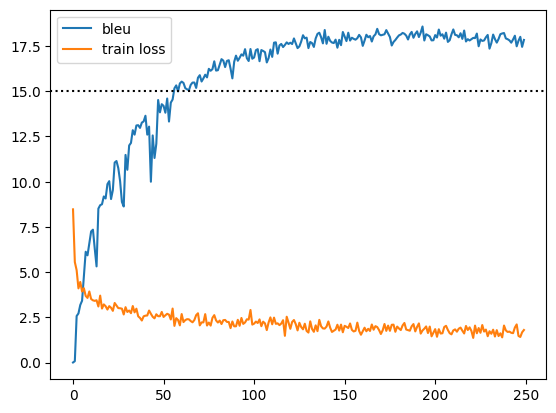

In [20]:
plt.plot(metrics['dev_bleu'], label='bleu')
plt.plot(metrics['train_loss'], label='train loss')
plt.axhline(15, color='black', linestyle='dotted')
plt.legend()

## Attention is all you need

### Задание 3

В этом разделе мы хотим, чтобы вы усовершенствовали базовую модель


Сначала напишем слой Attention, а потом внедрим его в уже существующий шаблон

### Attention layer (1 points)

На вход подается скрытые состояния encoder $h^e_0, h^e_1, h^e_2, ..., h^e_T$ и предыдущие состояние декодера $h^d$,

* Считаем логиты:
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получаем вероятности из логитов: 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвешиваем состояния энкодера с полученными вероятностями
$$ attn = \sum_t p_t \cdot h^e_t $$


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        super().__init__()
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 
        
        # опишите все слои, которые нужны Attention
        
        self.linearenc = nn.Linear(enc_size, hid_size, bias=False)
        self.lineardec = nn.Linear(dec_size, hid_size, bias=False)
        self.linearout = nn.Linear(hid_size, 1, bias=False)
    
    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ and веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
        """

        # считаем логиты
        logits = self.linearout(torch.tanh(self.linearenc(enc) + self.lineardec(dec).reshape(-1, 1, self.hid_size)))
        
        # Применим маску - если значение маски 0, логиты должны быть -inf или -1e9
        # Лучше использовать torch.where
        logits[torch.where(inp_mask == 0)] = -1e9
        
        # Примените softmax
        probs = F.softmax(logits, dim=1)
        
        # Подсчитайте выход attention используя enc состояния и вероятностями
        attn = torch.sum(probs * enc, dim=1)
        
        return attn, probs.squeeze(-1)

### Seq2seq model with attention (2 points)

Теперь вы можете использовать уровень внимания для построения сети. Самый простой способ реализовать внимание - использовать его на этапе декодирования:


На каждом шаге используйте предыдущее состояние декодера, и написанный слой Attention




In [ ]:
class AttentiveModel(BaseModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """Переводчик с Attention"""
        nn.Module.__init__(self)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        
        self.logits = nn.Linear(hid_size, len(out_voc))

        self.attention = AttentionLayer(enc_size = hid_size, dec_size = hid_size, hid_size=attn_size)
    
    def encode(self, inp, **flags):
        """
        Считаем скрытые скрытые состояния, которые используем в decode
        :param inp: матрица входных токенов
        """

        # делаем encode
        enc_seq, [waste_of_memory] = self.enc0(self.emb_inp(inp))
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)

        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)
        
        # apply attention layer from initial decoder hidden state
        # применяем attention слой для скрытых состояний
        first_attn_probas = self.attention(enc_seq, dec_start, lengths)
        
        # Для декодера нужно вернуть:
        # - начальное состояние для RNN декодера
        # - последовательность скрытых состояний encoder, maskа для них
        # - последним передаем вероятности слоя attention
        
        first_state = [dec_start, enc_seq, lengths, first_attn_probas]
        
        return first_state 
    
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логиты для следующих токенов
        :param prev_state: список тензоров предыдущих состояний декодера
        :param prev_tokens: предыдущие выходные токены [batch_size]
        :return: список тензоров состояния следующего декодера, тензор логитов [batch, n_tokens]
        """
        [prev_dec_state, enc_seq, lengths, first_attn_probas] = prev_state

        prev_emb = self.emb_out(prev_tokens)
        new_dec = self.dec0(prev_emb, prev_dec_state)

        attn, attn_probas = self.attention(enc_seq, new_dec, lengths)

        output_logits = self.logits(new_dec + attn)

        new_dec_state = [new_dec, enc_seq, lengths, attn_probas]

        return new_dec_state, output_logits

### Обучение модели (1 points)

Нужно обучить AttentiveModel и пройти assert по качеству

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)

model = AttentiveModel(inp_voc=inp_voc, out_voc=out_voc, emb_size=64, hid_size=128, attn_size=128).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

num_iter = 10000

for i in trange(num_iter):
  opt.zero_grad()
  
  # Сэмплим рандомный батч из тренировончых данных
  idxs = np.random.choice(len(train_inp), size=batch_size, replace=False)
  batch_inp = [train_inp[idx] for idx in idxs]
  batch_out = [train_out[idx] for idx in idxs]

  # Конвертируем батчи в тензора
  inp_tensor = inp_voc.to_matrix(batch_inp).to(device)
  out_tensor = out_voc.to_matrix(batch_out).to(device)

  # Считаем лосс и градиент
  loss = loss_function(model, inp_tensor, out_tensor)
  loss.backward()
  opt.step()

  # Каждые 100 итераций оцениваем модель
  if i % 100 == 0:
    clear_output(True)

    # Считаем трейн лосс
    train_loss = loss_function(model, inp_tensor, out_tensor).item()
    metrics['train_loss'].append(train_loss)

    # Считаем BLEU
    dev_bleu = compute_bleu(model, dev_inp, dev_out)
    metrics['dev_bleu'].append(dev_bleu)

    print(f"iteration {i}/{num_iter}: train_loss={train_loss:.3f}, dev_bleu={dev_bleu:.3f}")

 99%|█████████▉| 9903/10000 [15:09<00:24,  3.98it/s]

iteration 9900/10000: train_loss=2.077, dev_bleu=24.551


100%|██████████| 10000/10000 [15:17<00:00, 10.90it/s]


In [ ]:
dev_bleu = compute_bleu(model, dev_inp, dev_out)
print(f"Final dev BLEU: {dev_bleu:.3f}")

assert np.mean(metrics['dev_bleu'][-10:], axis=0) > 23, "Ты можешь больше! попробуй еще раз)"

Final dev BLEU: 24.599


In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
you will find a shared kitchen and a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bicycle rental and free parking are available .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the town of lucca is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
featuring a garden , garden , air - conditioned apartments , a garden and a sun terrace , the garden is 5 minutes ’ walk from the beach .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
located in moscow , 200 metres from the theatre of cefalù , this apartment features a balcony .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a shower , private bathrooms also come with towels .



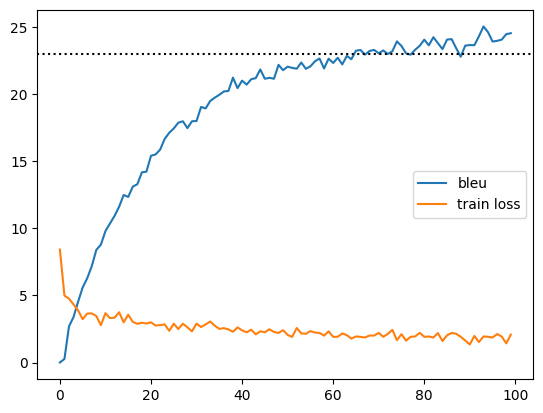

In [ ]:
plt.plot(metrics['dev_bleu'], label='bleu')
plt.plot(metrics['train_loss'], label='train loss')
plt.axhline(23, color='black', linestyle='dotted')
plt.legend()

## Как решать NLP задачу? Дообучить модель из huggingface

Как мы видели на последнем семинаре в прошлом модуле можно получить отлично качество генерации текста, написав при этом не очень много строк кода, может быть попробовать тут также?)

Это отличная идея!

### Задание 4 (2 points)
 
Нужно взять модель из [huggingface](https://huggingface.co/models?pipeline_tag=translation&sort=downloads), дообучить на наших данных и посмотреть, какое качество

In [ ]:
# https://huggingface.co/docs/transformers/model_doc/auto

In [ ]:
def preprocess_function(examples):
    inputs = [ex for ex in examples['input']]
    outputs = [ex for ex in examples['output']]
    tokenized_inputs = tokenizer(inputs, padding='max_length', truncation=True, max_length=128)
    tokenized_outputs = tokenizer(outputs, padding='max_length', truncation=True, max_length=128)
    return {
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],
        'labels': tokenized_outputs['input_ids'],
    }

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
!pip install transformers
!pip install datasets
!pip install transformers[sentencepiece]
!pip install sentencepiece
!pip install sacrebleu
!pip install sacremoses
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset, load_metric, Dataset

train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000, random_state=42)

metric = load_metric("sacrebleu")
model_checkpoint = "Helsinki-NLP/opus-mt-en-ru"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)


In [ ]:
train_dataset = Dataset.from_dict({'input': train_inp, 'output': train_out})
train_dataset = train_dataset.map(preprocess_function, batched=True)

dev_dataset = Dataset.from_dict({'input': dev_inp, 'output': dev_out})
dev_dataset = dev_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/47001 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=4,
    save_total_limit = 3,
    seed=42,
    predict_with_generate=True,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,0.345100,0.315289,20.902500,26.853700
2,0.286300,0.265129,24.184600,26.903300
3,0.233900,0.245913,26.935000,26.666000


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,0.345100,0.315289,20.902500,26.853700
2,0.286300,0.265129,24.184600,26.903300
3,0.233900,0.245913,26.935000,26.666000
4,0.211600,0.239336,28.139600,26.443000


TrainOutput(global_step=47004, training_loss=0.3028659204766249, metrics={'train_runtime': 7489.4751, 'train_samples_per_second': 25.102, 'train_steps_per_second': 6.276, 'total_flos': 6373028199923712.0, 'train_loss': 0.3028659204766249, 'epoch': 4.0})

In [ ]:
results = trainer.evaluate()
res_bleu = results['eval_bleu'] 

In [ ]:
res_bleu

28.1396

In [ ]:
assert res_bleu > 27, "Ты можешь больше! попробуй еще раз)"

In [ ]:
trainer.save_model('/content/weights')

from transformers import pipeline
model_checkpoint = '/content/weights'
translator = pipeline("translation", model=model_checkpoint)

In [ ]:
for i in range(len(dev_inp[::500])):
  print(f'входной текст: {str(dev_inp[::500][i])}')
  print('перевод: ', translator(str(dev_inp[::500][i]))[0]['translation_text'].replace('▁', ' '), '\n')

входной текст: в распоряжении гостей общая кухня и общая гостиная .
перевод:   there is a shared kitchen and a shared living room at the property . 

входной текст: кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
перевод:   bicycle rental , shuttle service and free parking are also available . 

входной текст: расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
перевод:  kis@@ si@@ mm@@ i is 26 km away . 

входной текст: апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
перевод:   featuring a shared outdoor pool , a garden , air conditioning and a sun terrace , this apartment is a 5 - minute walk from the beach in cab@@ o rai . 

входной текст: апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
перевод:   mos@@ co@@ w point - loft red square is located in moscow , 200